<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Submodular-Optimization-&amp;-Influence-Maximization" data-toc-modified-id="Submodular-Optimization-&amp;-Influence-Maximization-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Submodular Optimization &amp; Influence Maximization</a></span><ul class="toc-item"><li><span><a href="#Influence-Maximization-(IM)" data-toc-modified-id="Influence-Maximization-(IM)-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Influence Maximization (IM)</a></span></li><li><span><a href="#Getting-Started" data-toc-modified-id="Getting-Started-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Getting Started</a></span></li><li><span><a href="#Spread-Process---Independent-Cascade-(IC)" data-toc-modified-id="Spread-Process---Independent-Cascade-(IC)-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Spread Process - Independent Cascade (IC)</a></span></li><li><span><a href="#Greedy-Algorithm" data-toc-modified-id="Greedy-Algorithm-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Greedy Algorithm</a></span></li><li><span><a href="#Submodular-Optimization" data-toc-modified-id="Submodular-Optimization-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Submodular Optimization</a></span></li><li><span><a href="#Cost-Effective-Lazy-Forward-(CELF)-Algorithm" data-toc-modified-id="Cost-Effective-Lazy-Forward-(CELF)-Algorithm-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Cost Effective Lazy Forward (CELF) Algorithm</a></span></li><li><span><a href="#Larger-Network" data-toc-modified-id="Larger-Network-1.7"><span class="toc-item-num">1.7&nbsp;&nbsp;</span>Larger Network</a></span></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-1.8"><span class="toc-item-num">1.8&nbsp;&nbsp;</span>Conclusion</a></span></li></ul></li><li><span><a href="#Reference" data-toc-modified-id="Reference-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Reference</a></span></li></ul></div>

In [1]:
# code for loading the format for the notebook
import os

# path : store the current path to convert back to it later
path = os.getcwd()
os.chdir(os.path.join('..', '..', 'notebook_format'))

from formats import load_style
load_style(plot_style=False)

In [2]:
os.chdir(path)

# 1. magic for inline plot
# 2. magic to print version
# 3. magic so that the notebook will reload external python modules
# 4. magic to enable retina (high resolution) plots
# https://gist.github.com/minrk/3301035
%matplotlib inline
%load_ext watermark
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

import time
import numpy as np
import matplotlib.pyplot as plt
from igraph import Graph  # pip install python-igraph

%watermark -a 'Ethen' -d -t -v -p igraph,numpy,matplotlib

Ethen 2018-10-25 17:38:52 

CPython 3.6.4
IPython 6.4.0

igraph 0.7.1
numpy 1.14.1
matplotlib 2.2.2


# Submodular Optimization & Influence Maximization

The content and example in this documentation is build on top of the wonderful blog post at the following link. [Blog: Influence Maximization in Python - Greedy vs CELF](https://hautahi.com/im_greedycelf).  

## Influence Maximization (IM)

**Influence Maximization (IM)** is a field of network analysis with a lot of applications - from viral marketing to disease modeling and public health interventions. IM is the task of finding a small subset of nodes in a network such that the resulting "influence" propagating from that subset reaches the largest number of nodes in the network. "Influence" represents anything that can be passed across connected peers within a network, such as information, behavior, disease or product adoption. To make it even more concrete, IM can be used to answer the question:

> If we can try to convince a subset of individuals to adopt a new product or innovation, and the goal is to trigger a large cascade of further adoptions, which set of individuals should we target?

[Kempe et al. (2003)](https://www.cs.cornell.edu/home/kleinber/kdd03-inf.pdf) were the first to formalize IM as the following combinatorial optimization problem: Given a network with $n$ nodes and given a "spreading" or propagation process on that network, choose a "seed set" $S$ of size $k<n$ to maximize the number of nodes in the network that are ultimately influenced.

Solving this problem turns out to be extremely computationally burdensome. For example, in a relatively small network of 1,000 nodes, there are ${n\choose k} \approx 8$ trillion different possible candidates of size $k=5$ seed sets, which is impossible to solve directly even on state-of-the-art high performance computing resources. Consequently, over the last 15 years, researchers has been actively trying to find approximate solutions to the problem that can be solved quickly. This notebook walks through:

- How to implement two of the earliest and most fundamental approximation algorithms in Python - the Greedy and the CELF algorithms - and compares their performance.
- We will also spend some time discussing the field of submodular optimization, as it turns out, the combinatorial optimization problem we described above is submodular.

## Getting Started

We begin by loading a few modules. There are many popular network modeling packages, but we'll use the [`igraph`](http://igraph.org/python/) package. Don't worry if you're not acquainted with the library, we will explain the syntax, and if you like, you can even swap it out with a different graph library that you prefer.

We'll first test these algorithms to see if they can produce the correct solution for a simple example for which we know the two nodes which are the most influential. Below we create a 10-node/20-edge directed `igraph` network object. This artificially created network is designed to ensure that nodes `0` and `1` are the most influential. We do this by creating 8 links outgoing from each of these nodes compared to only 1 outgoing links for the other 8 nodes. We also ensure nodes `0` and `1` are not neighbors so that having one in the seed set does not make the other redundant.

In [3]:
source = [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 4, 5]
target = [2, 3, 4, 5, 6, 7, 8, 9, 2, 3, 4, 5, 6, 7, 8, 9, 6, 7, 8, 9]

# create a directed graph
graph = Graph(directed=True)

# add the nodes/vertices (the two are used interchangeably) and edges
# 1. the .add_vertices method adds the number of vertices
# to the graph and igraph uses integer vertex id starting from zero
# 2. to add edges, we call the .add_edges method, where edges
# are specified by a tuple of integers. 
graph.add_vertices(10)
graph.add_edges(zip(source,  target))
print('vertices count:',  graph.vcount())
print('edges count:',  graph.ecount())

# a graph api should allow us to retrieve the neighbors of a node
print('neighbors: ', graph.neighbors(2, mode='out'))

# or create an adjacency list of the graph,
# as we can see node 0 and 1 are the most influential
# as the two nodes are connected to a lot of other nodes
graph.get_adjlist()

vertices count: 10
edges count: 20
neighbors:  [6]


[[2, 3, 4, 5, 6, 7, 8, 9],
 [2, 3, 4, 5, 6, 7, 8, 9],
 [6],
 [7],
 [8],
 [9],
 [],
 [],
 [],
 []]

## Spread Process - Independent Cascade (IC)

IM algorithms solve the optimization problem for a given spread or propagation process. We therefore first need to specify a function that simulates the spread from a given seed set across the network. We'll simulate the influence spread using the popular **Independent Cascade (IC)** model, although there are many others we could have chosen.

Independent Cascade starts by having an initial set of seed nodes, $A_0$, that start the diffusion process, and the process unfolds in discrete steps according to the following randomized rule: 

When node $v$ first becomes active in step $t$, it is given a single chance to activate each currently inactive
neighbor $w$; this process succeeds with a probability $p_{v,w}$, a parameter of the system — independently of the history thus far. If $v$ succeeds, then $w$ will become active in step $t + 1$; but whether or not $v$ succeeds in this current step $t$, it cannot make any further attempts to activate $w$ in subsequent rounds. This process runs until no more activations are possible. Here, we assume that the nodes are progressive, meaning the node will only go from inactive to active, but not the other way around.

In [4]:
def compute_independent_cascade(graph, seed_nodes, prob, n_iters=1000):
    total_spead = 0

    # simulate the spread process over multiple runs
    for i in range(n_iters):
        np.random.seed(i)
        active = seed_nodes[:]
        new_active = seed_nodes[:]
        
        # for each newly activated nodes, find its neighbors that becomes activated
        while new_active:
            activated_nodes = []
            for node in new_active:
                neighbors = graph.neighbors(node, mode='out')
                success = np.random.uniform(0, 1, len(neighbors)) < prob
                activated_nodes += list(np.extract(success, neighbors))

            # ensure the newly activated nodes doesn't already exist
            # in the final list of activated nodes before adding them
            # to the final list
            new_active = list(set(activated_nodes) - set(active))
            active += new_active

        total_spead += len(active)

    return total_spead / n_iters


# assuming we start with 1 seed node
seed_nodes = [0]
compute_independent_cascade(graph, seed_nodes, prob=0.2)

2.74

We calculate the expected spread of a given seed set by taking the average over a large number of Monte Carlo simulations. The outer loop in the function iterates over each of these simulations and calculates the spread for each iteration, at the end, the mean of each iteration will be our unbiased estimation for the expected spread of the seed nodes we've provided. The actual number of simulation required is up to debate, through experiment I found 1,000 to work well enough, whereas 100 was too low. On the other hand, the paper even set the simulation number up to 10,000.

Within each Monte Carlo iteration, we simulate the spread of influence throughout the network over time, where a different "time period" occurs within each of the `while` loop iterations, which checks whether any new nodes were activated in the previous time step. If no new nodes were activated (when `new_active` is an empty list and therefore evaluates to `False`) then the independent cascade process terminates, and the function moves onto the next simulation after recording the total spread for this simulation. The term total spread here refers to the number of nodes ultimately activated (some algorithms are framed in terms of the "additional spread" in which case we would subtract the size of the seed set so the code would be amended to `len(active) - len(seed_nodes)`. 

## Greedy Algorithm

With our spread function in hand, we can now turn to the IM algorithms themselves. We begin with the **Greedy algorithm**. The method is referred to as greedy as it adds the node that currently provides the best spread to our solution set without considering if it is actually the optimal solution in the long run, to elaborate the process is:

- We start with an empty seed set/nodes.
- For all the nodes that are not in the seed set/nodes, we find the node with the largest spread and adds it to the seed
- We repeat step 2 until $k$ seed nodes are found.

This algorithm only needs to calculate the spread of $\sum_{i=0}^k (n-i)\approx kn$ nodes, which is just 5,000 in the case of our 1,000 node and $k=5$ network (a lot less that 8 trillion!). Of course, this computational improvement comes at the cost of the resulting seed set only being an approximate solution to the IM problem because it only considers the incremental spread of the $k$ nodes individually rather than combined. Fortunately, this seemingly naive greedy algorithm is theoretically guaranteed to choose a seed set whose spread will be at least 63% of the spread of the optimal seed set. The proof of the guarantee relies heavily on the "submodular" property of spread functions, which will be explained in more detail in later section.

The following `greedy()` function implements the algorithm. It produces the optimal set of `k` seed nodes for the graph `graph`. Apart from returning the optimal seed set, it also records average spread of that seed set along with a list showing the cumulative time taken to complete each iteration, we will use these information to compare with a different algorithm, CELF, in later section.

In [5]:
def greedy(graph, k, prob=0.2, n_iters=1000):
    """
    Find k nodes with the largest spread (determined by IC) from a igraph graph
    using the Greedy Algorithm.
    """

    # we will be storing elapsed time and spreads along the way, in a setting where
    # we only care about the final solution, we don't need to record these
    # additional information
    elapsed = []
    spreads = []
    solution = []
    start_time = time.time()

    for _ in range(k):
        best_node = -1
        best_spread = -np.inf

        # loop over nodes that are not yet in our final solution
        # to find biggest marginal gain
        nodes = set(range(graph.vcount())) - set(solution)
        for node in nodes:
            spread = compute_independent_cascade(graph, solution + [node], prob, n_iters)
            if spread > best_spread:
                best_spread = spread
                best_node = node

        solution.append(best_node)
        spreads.append(best_spread)

        elapse = round(time.time() - start_time, 3)
        elapsed.append(elapse)

    return solution, spreads, elapsed

In [6]:
# the result tells us greedy algorithm was able to find the two most influential
# node, node 0 and node 1
k = 2
prob = 0.2
n_iters = 1000
greedy_solution, greedy_spreads, greedy_elapsed = greedy(graph, k, prob, n_iters)
print('solution: ', greedy_solution)
print('spreads: ', greedy_spreads)
print('elapsed: ', greedy_elapsed)

solution:  [0, 1]
spreads:  [2.74, 5.098]
elapsed:  [0.263, 0.755]


## Submodular Optimization

Now that we have a brief understanding of the IM problem and taken a first stab at solving this problem, let's take a step back and formally discuss submodular optimization. **A function $f$ is said to be submodular if it satisfies the diminishing return property**. More formally, if we were given a ground set $V$, a function $f:2^V \rightarrow \mathbb{R}$ (the function's space is 2 power $V$, as the function can either contain or not contain each element in the set $V$). The submodular property is defined as:

\begin{align}
f(A \cup \{i\}) - f(A) \geq f(B \cup \{i\}) - f(B)
\end{align}

For any $A \subseteq B \subseteq V$ and $i \in V \setminus B$. Hence by adding any element $i$ to $A$, which is a subset of $B$ yields as least as much value (or more) if we were to add $i$ to $B$. In other words, the marginal gain of adding $i$ to $A$ should be greater or equal to the marginal gain of adding $i$ to $B$ if $A$ is a subset of $B$.

The next property is known as monotone. We say that a submodular function is monotone if for any $A \subseteq B
\subseteq V$, we have $f(A) \leq f(B)$. This means that adding more elements to a set cannot decrease its value.

For example: Let $f(X)=max(X)$. We have the set $X= \{1,2,3,4,5\}$, and we choose $A=\{1,2\}$ and $B=\{1,2,5\}$. Given those information, we can see $f(A)=2$ and $f(B)=5$ and the marginal gain of items 3,4 is :

\begin{align}
f(3 \, | \, A) = 1 \\ \nonumber
f(4 \, | \, B) = 0 \\ \nonumber
f(3 \, | \, A) = 2 \\ \nonumber
f(4 \, | \, B) = 0
\end{align}

Here we use the shorthand $f(i \, | \, A)$, to denote $f(A \cup \{i\}) - f(A)$.

Note that $f(i \, | \, A) \ge f(i \, | \, B)$ for any choice of $i$, $A$ and $B$. This is because $f$ is submodular and monotone. To recap, submodular functions has the diminishing return property saying adding an element to a larger set results in smaller marginal increase in the value of $f$ (compared to adding the element to a smaller set). And monotone ensures that adding additional element to the solution set does not decrease the function's value.

Since the functions we're dealing with functions that are monotone, the set with maximum value is always including everything from the ground set $V$. But what we're actually interested in is when we impose a cardinality constraint - that is, finding the set of size at most k that maximizes the utility. Formally:

\begin{align}
A^* = \underset{A: |A| \leq k}{\text{argmax}} \,\, f(A)
\end{align}

For instance, in our IM problem, we are interested in finding the subset $k$ nodes that generates the largest influence. The greedy algorithm we showed above is one approach of solving this combinatorial problem.

- Given a ground set $V$, if we're interested in populating a solution set of size $k$.
- The algorithm starts with the empty set $A_0$
- Then repeats the following step for $i = 0, ... , (k-1)$:

\begin{align}
A_{i+1} = A_{i} \cup \{ \underset{v \in V \setminus A_i}{\text{argmax}} \,\, f(A_i \cup \{v\}) \}
\end{align}

From a theoretical standpoint, this procedure guarantees a solution that has a score of 0.63 of the optimal set.

In [7]:
# if we check the solutions from the greedy algorithm we've
# implemented above, we can see that our solution is in fact
# submodular, as the spread we get is in diminshing order
np.diff(np.hstack([np.array([0]), greedy_spreads]))

array([2.74 , 2.358])

## Cost Effective Lazy Forward (CELF) Algorithm

**CELF Algorithm** was developed by [Leskovec et al. (2007)](https://www.cs.cmu.edu/~jure/pubs/detect-kdd07.pdf). In other places, this is referred to as the **Lazy Greedy Algorithm**. Although the Greedy algorithm is much quicker than solving the full problem, it is still very slow when used on realistically sized networks. CELF was one of the first significant subsequent improvements.

CELF exploits the sub-modularity property of the spread function, which implies that the marginal spread of a given node in one iteration of the Greedy algorithm cannot be any larger than its marginal spread in the previous iteration. This helps us to choose the nodes for which we evaluate the spread function in a more sophisticated manner, rather than simply evaluating the spread for all nodes. More specifically, in the first round, we calculate the spread for all nodes (like Greedy) and store them in a list/heap, which is then sorted. Naturally, the top node is added to the seed set in the first iteration, and then removed from the list/heap. In the next iteration, only the spread for the top node is calculated. If, after resorting, that node remains at the top of the list/heap, then it must have the highest marginal gain of all nodes. Why? Because we know that if we calculated the marginal gain for all other nodes, they'd be lower than the value currently in the list (due to submodularity) and therefore the "top node" would remain on top. This process continues, finding the node that remains on top after calculating its marginal spread, and then adding it to the seed set. By avoiding calculating the spread for many nodes, CELF turns out to be much faster than Greedy, which we'll show below.

The `celf()` function below that implements the algorithm, is split into two components. The first component, like the Greedy algorithm, iterates over each node in the graph and selects the node with the highest spread into the seed set. However, it also stores the spreads of each node for use in the second component.

The second component iterates to find the remaining $k-1$ seed nodes. Within each iteration, the algorithm evaluates the marginal spread of the top node. If, after resorting, the top node stays in place then that node is selected as the next seed node. If not, then the marginal spread of the new top node is evaluated and so on.

Like `greedy()`, the function returns the optimal seed set, the resulting spread and the time taken to compute each iteration. In addition, it also returns the list `lookups`, which keeps track of how many spread calculations were performed at each iteration. We didn't bother doing this for `greedy()` because we know the number of spread calculations in iteration $i$ is $N-i-1$.

In [8]:
import heapq


def celf(graph, k, prob, n_iters=1000):
    """
    Find k nodes with the largest spread (determined by IC) from a igraph graph
    using the Cost Effective Lazy Forward Algorithm, a.k.a Lazy Greedy Algorithm.
    """
    start_time = time.time()

    # find the first node with greedy algorithm:
    # python's heap is a min-heap, thus
    # we negate the spread to get the node
    # with the maximum spread when popping from the heap
    gains = []
    for node in range(graph.vcount()):
        spread = compute_independent_cascade(graph, [node], prob, n_iters)
        heapq.heappush(gains, (-spread, node))

    # we pop the heap to get the node with the best spread,
    # when storing the spread to negate it again to store the actual spread
    spread, node = heapq.heappop(gains)
    solution = [node]
    spread = -spread
    spreads = [spread]

    # record the number of times the spread is computed
    lookups = [graph.vcount()]
    elapsed = [round(time.time() - start_time, 3)]

    for _ in range(k - 1):
        node_lookup = 0
        matched = False

        while not matched:
            node_lookup += 1

            # here we need to compute the marginal gain of adding the current node
            # to the solution, instead of just the gain, i.e. we need to subtract
            # the spread without adding the current node
            _, current_node = heapq.heappop(gains)
            spread_gain = compute_independent_cascade(
                graph, solution + [current_node], prob, n_iters) - spread

            # check if the previous top node stayed on the top after pushing
            # the marginal gain to the heap
            heapq.heappush(gains, (-spread_gain, current_node))
            matched = gains[0][1] == current_node

        # spread stores the cumulative spread
        spread_gain, node = heapq.heappop(gains)
        spread -= spread_gain
        solution.append(node)
        spreads.append(spread)
        lookups.append(node_lookup)

        elapse = round(time.time() - start_time, 3)
        elapsed.append(elapse)

    return solution, spreads, elapsed, lookups

In [9]:
k = 2
prob = 0.2
n_iters = 1000

celf_solution, celf_spreads, celf_elapsed, celf_lookups = celf(graph, k, prob, n_iters)
print('solution: ', celf_solution)
print('spreads: ', celf_spreads)
print('elapsed: ', celf_elapsed)
print('lookups: ', celf_lookups)

solution:  [0, 1]
spreads:  [2.74, 5.098]
elapsed:  [0.257, 0.327]
lookups:  [10, 1]


## Larger Network

Now that we know both algorithms at least work correctly for a simple network for which we know the answer, we move on to a more generic graph to compare the performance and efficiency of each method. Any `igraph` network object will work, but for the purposes of this post we will use a random Erdos-Renyi graph with 100 nodes and 300 edges. The exact type of graph doesn't matter as the main points hold for any graph. Rather than explicitly defining the nodes and edges like we did above, here we make use of the `.Erdos_Renyi()` method to automatically create the graph.

In [10]:
np.random.seed(1234)
graph = Graph.Erdos_Renyi(n=100, m=300, directed=True)

Given the graph, we again compare both optimizers with the same parameter. Again for the `n_iters` parameter, it is not uncommon to see it set to a much higher number in literatures, such as 10,000 to get a more accurate estimate of spread, we chose a lower number here so we don't have to wait as long for the results

In [11]:
k = 10
prob = 0.1
n_iters = 1500
celf_solution, celf_spreads, celf_elapsed, celf_lookups = celf(graph, k, prob, n_iters)
greedy_solution, greedy_spreads, greedy_elapsed = greedy(graph, k, prob, n_iters)

# print resulting solution
print('celf output:   ' + str(celf_solution))
print('greedy output: ' + str(greedy_solution))

celf output:   [95, 6, 61, 42, 29, 97, 52, 12, 98, 58]
greedy output: [95, 6, 61, 42, 29, 97, 52, 12, 98, 58]


Thankfully, both optimization method yields the same solution set.

In the next few code chunk, we  will use some of the information we've stored while performing the optimizing to perform a more thorough comparison. First, by plotting the resulting expected spread from both optimization method. We can see both methods yield the same expected spread.

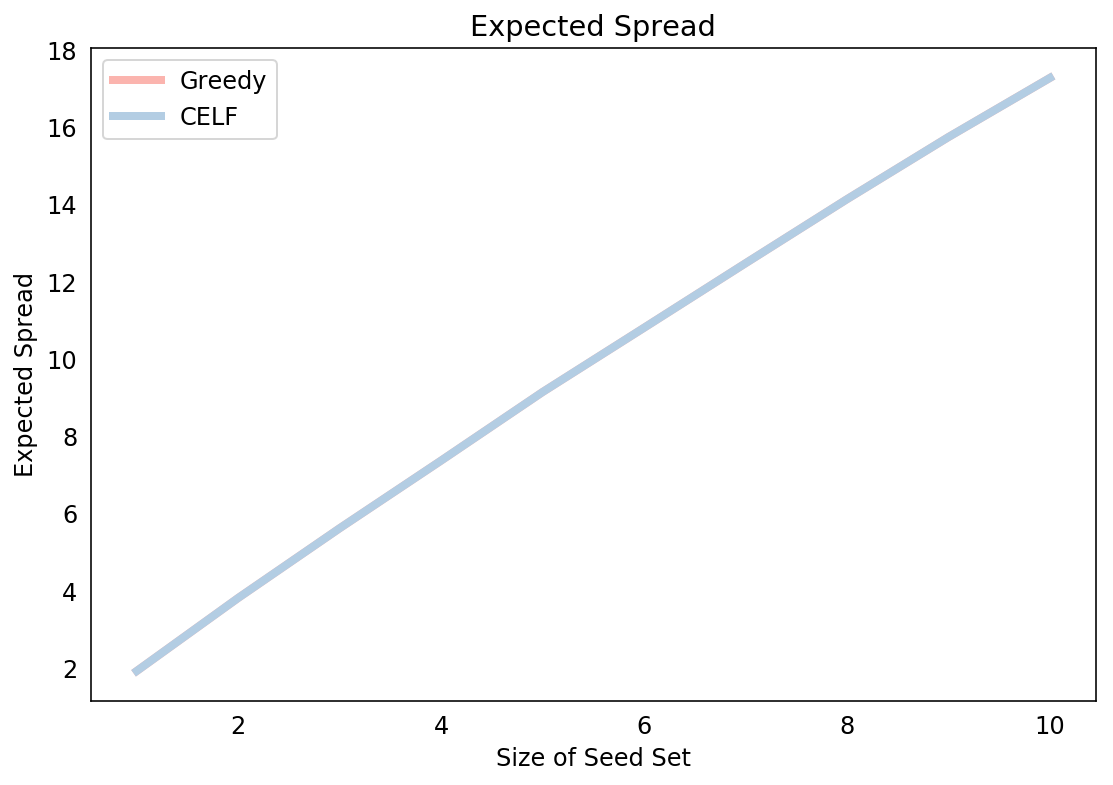

In [12]:
# change default style figure and font size
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['font.size'] = 12

lw = 4
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.plot(range(1, len(greedy_spreads) + 1), greedy_spreads, label="Greedy", color="#FBB4AE", lw=lw)
ax.plot(range(1, len(celf_spreads) + 1), celf_spreads, label="CELF", color="#B3CDE3", lw=lw)
ax.legend(loc=2)
plt.ylabel('Expected Spread')
plt.title('Expected Spread')
plt.xlabel('Size of Seed Set')
plt.tick_params(bottom=False, left=False)
plt.show()

We now compare the speed of each algorithm. The plot below shows that the computation time of Greedy is larger than CELF for all seed set sizes greater than 1 and the difference in computational times grows exponentially with the size of the seed set. This is because Greedy must compute the spread of $N-i-1$ nodes in iteration $i$ whereas CELF generally performs far fewer spread computations after the first iteration.

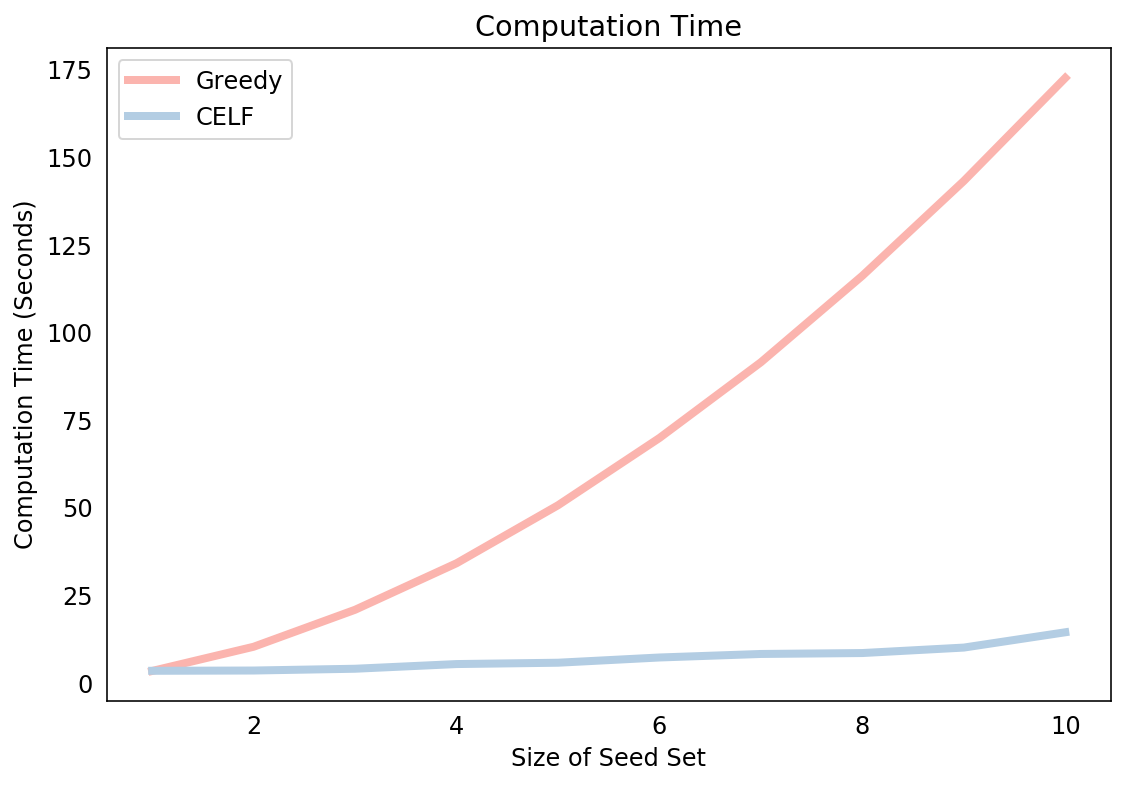

In [13]:
lw = 4
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.plot(range(1, len(greedy_elapsed) + 1), greedy_elapsed, label="Greedy", color="#FBB4AE", lw=lw)
ax.plot(range(1, len(celf_elapsed) + 1), celf_elapsed, label="CELF", color="#B3CDE3", lw=lw)
ax.legend(loc=2)
plt.ylabel('Computation Time (Seconds)')
plt.xlabel('Size of Seed Set')
plt.title('Computation Time')
plt.tick_params(bottom=False, left=False)
plt.show()

We can get some further insight into the superior computational efficiency of CELF by observing how many "node lookups" it had to perform during each of the 10 rounds. The list that records this information shows that the first round iterated over all 100 nodes of the network. This is identical to Greedy which is why the graph above shows that the running time is equivalent for $k=1$. However, for subsequent iterations, there are far fewer spread computations because the marginal spread of a node in a previous iteration is a good indicator for its marginal spread in a future iteration. Note the relationship between the values below and the corresponding computation time presented in the graph above. There is a visible jump in the blue line for higher values of the "node lookups". This again solidifies the fact that while CELF produces identical solution set as Greedy, it usually has enormous speedups over the standard Greedy procedure.

In [14]:
celf_lookups

[100, 1, 4, 9, 2, 7, 4, 1, 5, 13]

## Conclusion

We implemented both the Greedy and CELF algorithms and showed the following:

- Both correctly identify the influential nodes in simple examples
- Both result in the same seed set for a larger example.
- The CELF algorithm runs a lot faster for any seed set $k>1$. The speed arises from the fact that after the first round, CELF performs far fewer spread computations than Greedy.
- During the Greedy Algorithm section, we mentioned briefly that a natural greedy strategy obtains a solution that is provably within 63% of optimal. We didn't formally proved this statement here, but there are several good notes online that goes more in-depth into the proof behind this. [Notes: N. Buchbinder, M.Feldman - Submodular Functions Maximization Problems (2017)](https://www.openu.ac.il/personal_sites/moran-feldman/publications/Handbook2018.pdf)

# Reference

- [Blog: Influence Maximization in Python - Greedy vs CELF](https://hautahi.com/im_greedycelf)
- [Blog: The greedy algorithm for monotone submodular maximization](https://homes.cs.washington.edu/~marcotcr/blog/greedy-submodular/)
- [Paper: D. Kempe, J. Kleinberg, E. Tardos - Maximizing the Spread of Influence through a Social
Network (2003)](https://www.cs.cornell.edu/home/kleinber/kdd03-inf.pdf)
- [Notes: N. Buchbinder, M.Feldman - Submodular Functions Maximization Problems (2017)](https://www.openu.ac.il/personal_sites/moran-feldman/publications/Handbook2018.pdf)